In [1]:
import os
import math

import torch
import torch.nn.functional as F
from torch.utils.tensorboard import SummaryWriter
import numpy as np
from tqdm import tqdm
from PIL import Image, ImageDraw

from scorefield.models.ddpm.denoising_diffusion import Unet
from scorefield.models.heat.heat_diffusion import HeatDiffusion
from scorefield.utils.rl_utils import load_config
from scorefield.utils.utils import (
    gen_goals, overlay_goal, overlay_multiple, combine_objects, overlay_images,
    overlay_goal_agent, overlay_goals_agent, log_num_check,
    draw_obstacles_pil, convert_to_obstacle_masks,
    randgen_obstacle_masks, draw_obstacles_pixel,
    vector_field, clip_vectors
)
from scorefield.utils.diffusion_utils import bilinear_interpolate, bilinear_interpolate_batch, bilinear_interpolate_version

import matplotlib.pyplot as plt
import itertools
from typing import Optional

/home/mlcs_edf/mambaforge/envs/diffusion/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Args
config_dir = "./scorefield/configs/heat_diffusion.yaml"
args = load_config(config_dir)
device = args['device']

bg = Image.open('assets/toy_exp/background0.png')
wastes = []
wastes.append(Image.open('assets/toy_exp/waste0.png'))
# wastes.append(Image.open('assets/toy_exp/waste4.png'))
# wastes.append(Image.open('assets/toy_exp/waste5.png'))


img_size = args['image_size']
goal_bounds = args['goal_bounds']
goal_num = len(wastes)
agent_bounds = args['agent_bounds']
obstacle_pos = args['obstacles']

model_path = os.path.join(args['log_path'], args['model_path'])

u0 = args['u0']
heat_steps = args['heat_steps']
noise_steps = args['noise_steps']
sample_num = args['sample_num']
time_type = args['time_type']

epochs = args['epochs']
train_lr = args['train_lr']
iterations = args['iterations']
random_goals = args['random_goals']
batch_size = noise_steps * sample_num #args['batch_size']


In [3]:
class Unet2D(Unet):
    def __init__(
        self, 
        dim, 
        out_dim, 
        dim_mults=(1, 2, 4, 8),
    ):
        super().__init__(dim=dim, out_dim=out_dim, dim_mults=dim_mults)

    def forward(self, obs, t, x_t:Optional[torch.Tensor]=None):
        score_map = super().forward(obs, t)
        if x_t is not None:
            score = bilinear_interpolate(score_map, x_t)    # output: (B,2)
            return score, score_map.permute(0,2,3,1)
        else:
            return score_map.permute(0, 2, 3, 1)
    
model = Unet2D(
    dim=img_size,
    out_dim = 2,
    dim_mults = (1, 2, 4, 8),
).to(device)

diffusion = HeatDiffusion(
    image_size=img_size,
    u0 = u0,
    noise_steps=noise_steps,
    heat_steps=heat_steps,
    time_type=time_type,
    device=device,
)

optim = torch.optim.Adam(params=model.parameters(), lr=train_lr)

tensor([    1,     5,    16,    48,   133,   364,   994,  2705,  7356, 20000],
       device='cuda:0')


In [ ]:
writer = SummaryWriter()

# Train with random single goal
assert (batch_size // random_goals) % sample_num == 0, 'batch size has to be divided by sample x_t nums'
# obstacle_masks = randgen_obstacle_masks(epochs, img_size)
# background = draw_obstacles_pixel(bg, obstacle_masks)

background = draw_obstacles_pil(bg, obstacle_pos)
obstacle_masks = convert_to_obstacle_masks(batch_size, background[0].size, img_size, obstacle_pos)

for epoch in range(epochs):
    for iters in tqdm(range(iterations)):
        goals = gen_goals(goal_bounds, random_goals, img_size, obstacles=obstacle_masks)
        goal = (torch.rand(batch_size, 1, 2, device=device, dtype=torch.float32) * 0.2 - 0.1) \
                    * 0.1 + goals.repeat(batch_size, 1, 1)
    
        obs = overlay_goal(background, img_size, wastes, goal)
        
        optim.zero_grad()

        # t = diffusion.sample_timesteps(batch_size//(sample_num)).to(device)
        t = torch.arange(1, noise_steps+1, device=device)
        with torch.no_grad():
            _, score, _, x_t = diffusion.forward_diffusion(t, goal.squeeze(1), sample_num, obstacle_masks)
        score_pred, _ = model(obs, t.repeat_interleave(sample_num), x_t)

        loss = F.mse_loss(score_pred, score)
        # loss = F.l1_loss(score_pred, score)

        writer.add_scalar("Loss/train", loss.item(), epoch*iterations+iters)
        loss.backward()
        optim.step()
        
        # if iters % 100 == 0:
        #     print(f"iter {iters}: {loss.item()}")   
writer.close()


In [ ]:
# Train with single goal
# bg = pil_to_pixel(bg, obstacle_pos)
# obstacle_masks = convert_to_obstacle_masks(batch_size, bg.size, img_size, obstacle_pos)
losses=[]

obstacle_masks = randgen_obstacle_masks(epochs, img_size)
background = draw_obstacles_pixel(bg, obstacle_masks)
goals = gen_goals(goal_bounds, epochs, img_size, obstacles=obstacle_masks)

obstacle_masks = obstacle_masks.repeat(batch_size, 1, 1)
goals = goals.repeat(batch_size, 1, 1)

for epoch in range(epochs):
    for iters in tqdm(range(iterations)):
        goal = (torch.rand(batch_size, 1, 2, device=device, dtype=torch.float32) * 0.2 - 0.1) \
                    * 0.1 + goals
        obs = overlay_goal(background, img_size, wastes, goal)
        optim.zero_grad()

        t = diffusion.sample_timesteps(batch_size).to(device)
        with torch.no_grad():
            _, score, _, x_t = diffusion.forward_diffusion(t, goal.squeeze(1), obstacle_masks)
            
        score_pred = model(obs, t, x_t.unsqueeze(1)).squeeze(1)

    #     loss = F.mse_loss(score, score_pred)
        loss = F.l1_loss(score_pred, score)
        loss.backward()
        optim.step()
    
        if iters % 200 == 0:
            print(f"iter {iters}: {loss.item()}")
            losses.append(loss.item())
        


In [ ]:
# visualize heat or score field for random goals and maps
obstacle_masks = randgen_obstacle_masks(1, img_size)
background = draw_obstacles_pixel(bg, obstacle_masks)
goal = gen_goals(goal_bounds, 1, img_size, obstacles=obstacle_masks)

obstacle_masks = obstacle_masks.repeat(noise_steps, 1, 1)
goal = goal.repeat(noise_steps, 1, 1)

obs = overlay_goal(background, img_size, wastes, goal)
# t = torch.tensor([noise_steps-1 for _ n range(batch_size)], device=device)
t = torch.tensor([i for i in range(1, noise_steps+1)], device=device)
_, score_field, _ = diffusion.forward_diffusion(t, goal.squeeze(1), obstacle_masks)

In [4]:
# visualize heat or score field
obstacle_masks = convert_to_obstacle_masks(noise_steps, bg.size, img_size, obstacle_pos)
background = draw_obstacles_pixel(bg, obstacle_masks)
goal = torch.tensor([[[-0.7,-0.]]]*noise_steps, device=device)
obs = overlay_goal(background, img_size, wastes, goal)
t = torch.tensor([i for i in range(1, noise_steps+1, sample_num)], device=device)
heat, score, score_field, xt,_ = diffusion.forward_diffusion(t, goal, sample_num, obstacle_masks)

In [ ]:
plt.imshow(obs[0].permute(1,2,0).cpu().numpy())
plt.show()

tensor(5.5624, device='cuda:0') tensor(-5.5624, device='cuda:0')


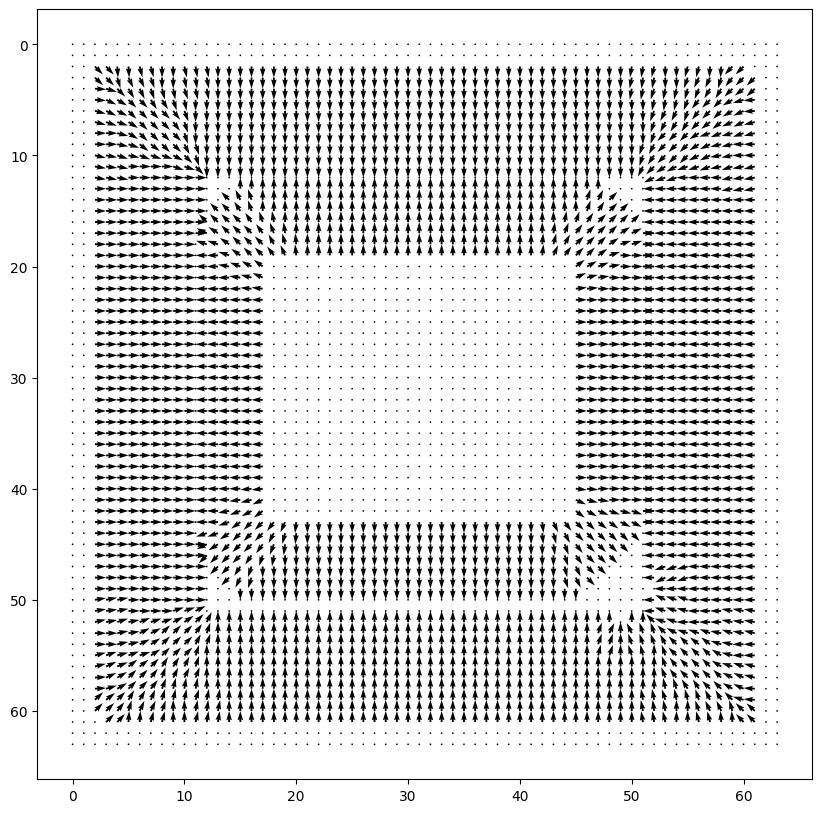

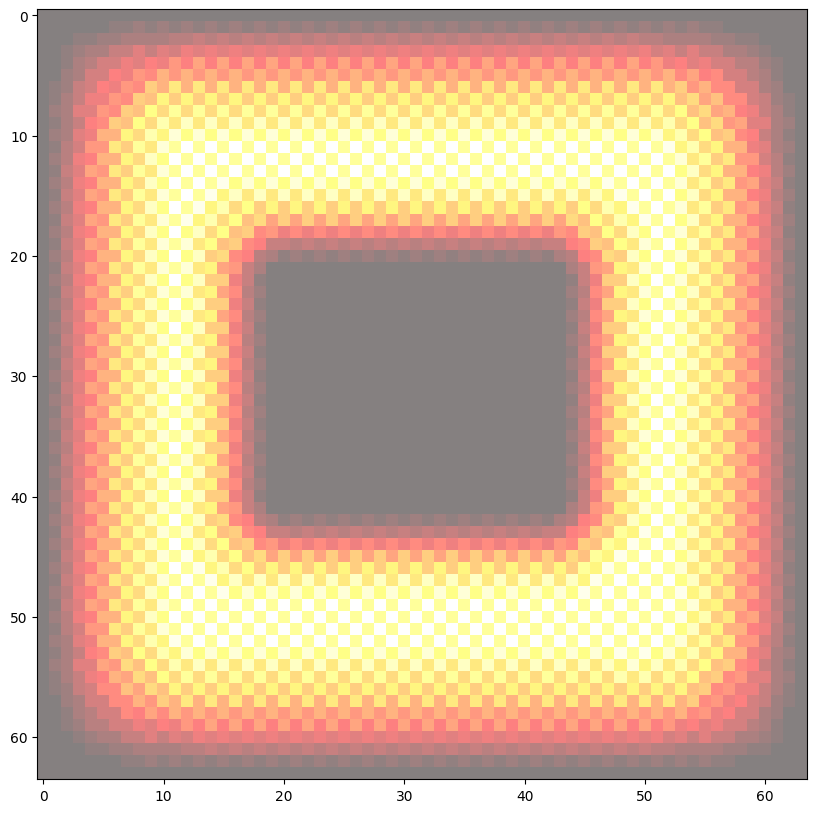

In [5]:
i = -1
data = score_field[i]
print(data.max(), data.min())
V = data[...,0]
U = data[...,1]

V_clip, U_clip = clip_vectors(V, U, 0.01)
# V_clip, U_clip = V, U
x, y = np.meshgrid(np.linspace(0, img_size-1, img_size), np.linspace(0,img_size-1,img_size))

plt.figure(figsize=(10, 10))
plt.quiver(x, y, U_clip.cpu().numpy(), V_clip.cpu().numpy(), angles='xy', scale_units='xy', scale=0.01)
plt.gca().invert_yaxis()
plt.show()
# plt.imshow(obs[i].permute(1,2,0).cpu().numpy())
# plt.show()
plt.figure(figsize=(10, 10))
plt.imshow(heat[i].cpu().numpy(),cmap='hot', interpolation='nearest', origin='upper', alpha=0.5)#, vmax=heat[i].max()*0.0005)
# plt.colorbar()
plt.show()

In [ ]:
# Train with single + multiple goals

train_goal_num = goal_num * (2**(goal_num - 1)) # if 3 goals: 12
train_goals = [len(list(itertools.combinations([i for i in range(goal_num)], i+1))* (i+1)) \
               for i in range(goal_num)] # if 3 goals: [3, 6, 3]
train_comb = [len(list(itertools.combinations([i for i in range(goal_num)], i+1))) \
              for i in range(goal_num)] # just a list of combinations of goal num. if 3: [3, 3, 1]

obstacle_masks = randgen_obstacle_masks(1, img_size)[0].repeat(train_goal_num, 1, 1)
background = draw_obstacles_pixel(bg, obstacle_masks)

assert batch_size % train_goal_num == 0, 'batch size has to be divided by the goal number'
n = batch_size // train_goal_num  # if 3 goals: batch -> n * 12 


for iters in tqdm(range(train_goal_num * iterations)):    
    goals = gen_goals(goal_bounds, train_goal_num, obstacle_masks)
    goal_pos = (torch.rand(train_goal_num, 1, 2, device=device, dtype=torch.float32) * 0.2 - 0.1) \
                    * 0.1 + goals
    
    optim.zero_grad()
    
    obs = []
    st = 0
    for i, t in enumerate(train_goals):
        if i == 0: 
            obs.append(overlay_goal(background, img_size, wastes, goal_pos[st:st + n * t]))
        else:
            obs.append(overlay_images(background, img_size, wastes, goal_pos[st:st + n * t], i+1))
        st = st + n * t
    x0 = goal_pos.unsqueeze(1)
    obs = torch.cat(obs, dim=0)
    raise
    
    # duplicate obs to match the size with x0
    duplicates = []
    for i, tr in enumerate(train_comb):
        if i > 0: 
            duplicates.append(obs[n*prev_tr:n*(prev_tr + tr)].repeat(i,1,1,1))
            tr = prev_tr + tr
        prev_tr = tr

    # TODO: Below new_obs is only capable when the goal number is 3.
    comb_sum = [0] + [n*(train_comb[c]+train_comb[c+1]) for c in range(len(train_comb)-1)]
    new_obs = torch.cat([obs[comb_sum[n//2]:comb_sum[n//2+1]] if n%2 == 0 else duplicates[n-1] \
                         for n in range(len(comb_sum)-1)*2], dim=0)
#     new_obs = torch.cat([
#         obs[:n*(train_comb[0]+train_comb[1])],
#         duplicates[0],
#         obs[n*(train_comb[0]+train_comb[1]):n*(train_comb[0]+train_comb[1]+train_comb[2])],
#         duplicates[1],
#         obs[14:]
#     ], dim=0)
        
    t = diffusion.sample_timesteps(batch_size).to(device)
    
    score, _, x_t = diffusion.forward_diffusion(x0, t)
    score_pred = model(new_obs, t, x_t)
    loss =  F.l1_loss(score, score_pred)

    loss.backward()
    optim.step()
    
    if iters % (epochs//10) == 0:
        print(f"iter {iters}: {loss.item()}")


In [16]:
from scorefield.utils.utils import log_num_check, get_url_pretrained

model_pth = f"./logs/pretrained/rand_goal_heat_n:{noise_steps}_h:{heat_steps}.pt"
model_pth = log_num_check(model_pth)
torch.save(model.state_dict(), model_pth)

# url = 'https://drive.google.com/uc?export=download&id=1CtqczM5cry7wg4poiCv_UeKfIrLtrx9V'
# get_url_pretrained(url, 'model.pt')
# model.load_state_dict(torch.load(f'./logs/pretrained/random_heat_n:{noise_steps}_h:{heat_steps}_0.pt'))

In [ ]:
bg = gen_obstacles(bg, obstacle_pos)
new_goals = torch.tensor([[[-0.7, -0.]]]*goal_num, device=device, dtype=torch.float32)
obs_T = convert_to_obstacle_masks(bg, img_size, wastes, new_goals) # (goal_num, 3, H, W)

t = torch.tensor([1], device=device)
score = model(obs_T, t).squeeze(0)

V = score[...,0]
U = score[...,1]

# V_clip, U_clip = clip_vectors(V, U, 0.01)
V_clip, U_clip = V, U

x, y = np.meshgrid(np.linspace(0, img_size-1, img_size), np.linspace(0,img_size-1,img_size))

plt.figure(figsize=(10, 10))
plt.gca().invert_yaxis()
plt.quiver(x, y, U_clip.cpu().detach().numpy(), V_clip.cpu().detach().numpy(), angles='xy', scale_units='xy', scale=10)
# x = torch.tensor([[[0.7, -0.7]]], device=device)
# t = torch.tensor([5], device=device)
# score = model(obs_T, t).squeeze(0) # (H,W,2)


# max_norm = 0.4
# score_norm = torch.norm(score, dim=-1, keepdim=True) # (H,W,1)
# score_clipped = torch.where(score_norm > max_norm, score / score_norm * max_norm, score_norm)

# V = score_clipped[...,0].cpu().detach().numpy()
# U = score_clipped[...,1].cpu().detach().numpy()

# x, y = np.meshgrid(np.linspace(0, 127, 128), np.linspace(0, 127, 128))

# plt.figure(figsize=(20, 20))
# plt.quiver(x, y, U, V, angles='xy', scale_units='xy', scale=max_norm)
# plt.gca().invert_yaxis()
# plt.show()

In [ ]:
score = model(obs_T, torch.tensor([1], device=device))
print(score[0][10,40])
data = score[0]
V = data[...,0]
U = data[...,1]

# V_clip, U_clip = clip_vectors(V, U, 0.01)
V_clip, U_clip = V, U
x, y = np.meshgrid(np.linspace(0, img_size-1, img_size), np.linspace(0,img_size-1,img_size))
plt.figure(figsize=(8, 8))
plt.quiver(x, y, U_clip.detach().cpu().numpy(), V_clip.detach().cpu().numpy(), angles='xy', scale_units='xy', scale=0.1)
plt.gca().invert_yaxis()
plt.show()

In [ ]:
# Evaluation Set up (single map & goal)
obstacle_masks = randgen_obstacle_masks(1, img_size)
background = draw_obstacles_pixel(bg, obstacle_masks)
plt.imshow(background[0])
plt.show()

9it [01:43, 11.51s/it]


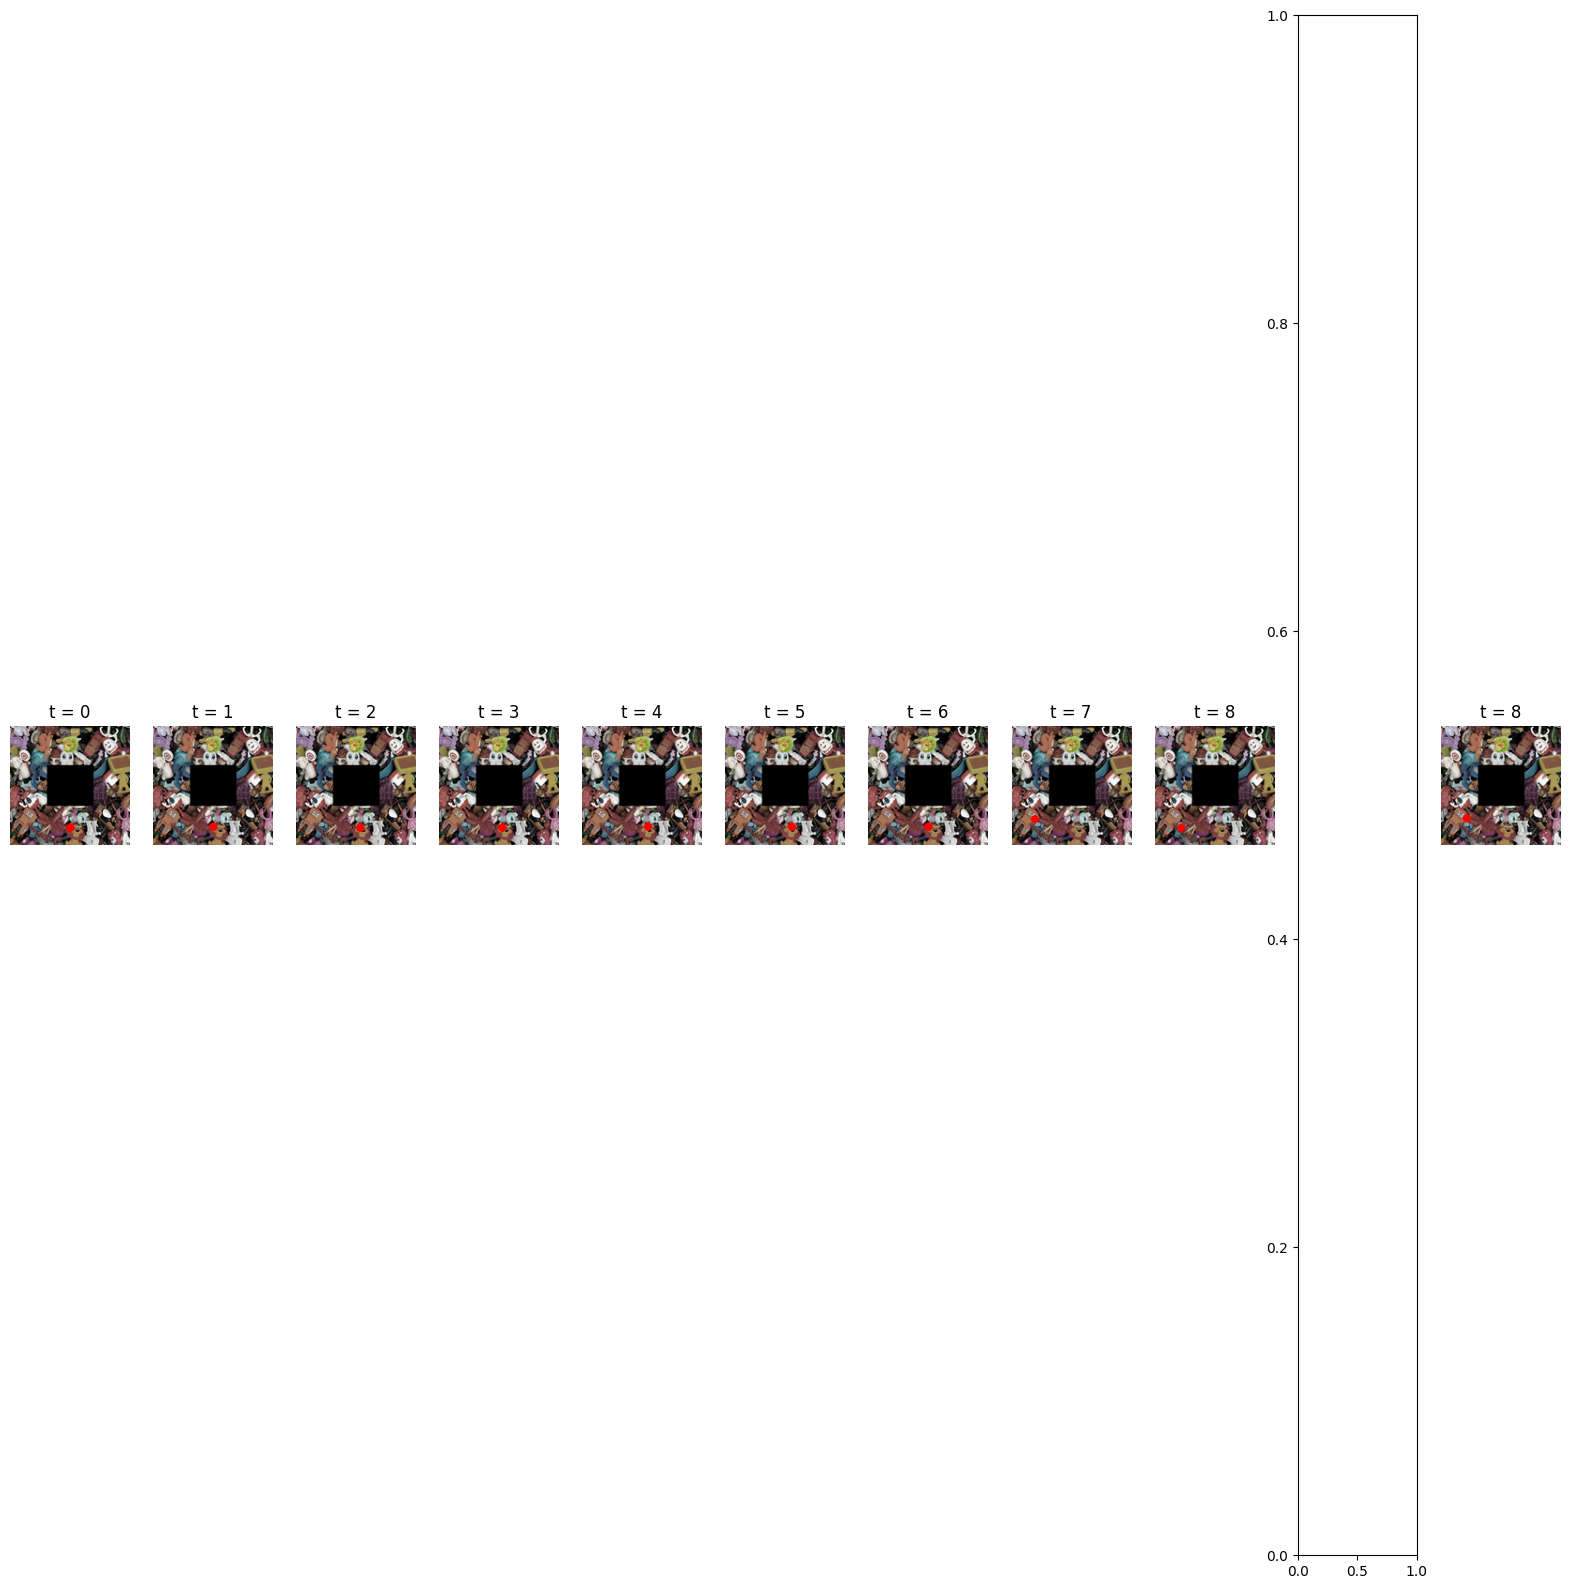

In [6]:
# Evaluation - Single goal

lan_t = 500  # 4
epsilon = 1.0

# obstacle_masks = gen_obstacle_masks(batch_size, bg.size, img_size, obstacle_pos)
# bg = gen_obstacles(bg, obstacle_pos)
# new_goals = torch.tensor([[[-0.7, -0.7]]]*goal_num, device=device, dtype=torch.float32)
# obs_T = overlay_goal(bg, img_size, wastes, new_goals) # (goal_num, 3, H, W)

# goals = gen_goals(goal_bounds, 1, img_size, obstacles=obstacle_masks)  
# goals = torch.tensor([[[0.7, -0.7]]], device=device, dtype=torch.float32)
# obs_T = overlay_goal(background, img_size, wastes, goals)

obstacle_masks = obstacle_masks[0].unsqueeze(0)
goals = torch.tensor([[[-0.7, 0]]], device=device, dtype=torch.float32)
obs_T = overlay_goal(background, img_size, wastes, goals)


c = 10
fig,axs = plt.subplots(goal_num, c + 1, figsize=(20,20))

T = diffusion.noise_steps
step_size = int(T / c)
dot_size = 4

model.eval()
ims = []
score_fields = []
with torch.no_grad():
    x_T = torch.tensor([[[0.7, -0]]], device=device, dtype=torch.float32)
    # x_T = gen_goals(agent_bounds, n=(goal_num, 1))
    x = x_T
    
    for i in tqdm(reversed(range(1, noise_steps)), position=0):
#         bkg = bg.copy()
        bkg = background.copy()
        im = overlay_goal_agent(bkg[0], wastes, goals.cpu(), x.cpu(), dot_size)
        ims.append(im)

        if (T-1-i) % step_size == 0:
            k = (T-1-i) // step_size
            backg = background.copy()
            img_sample = overlay_goal_agent(backg[0], wastes, goals.cpu(), x.cpu(), dot_size)
            for s in range(len(img_sample)):
                if len(img_sample) == 1:
                    axs[k].imshow(img_sample[s])
                    axs[k].set_title(f't = {T-1-i}')
                    axs[k].axis('off')    
                else:
                    axs[s,k].imshow(img_sample[s])
                    axs[0,k].set_title(f't = {T-1-i}')
                    axs[s,k].axis('off')

        t = (torch.ones(1) * i).long().to(device)

        alpha = epsilon * (t / T)
        for _ in range(lan_t):
            x_prev = x.clone()
            score, score_field = model(obs_T, t, x.squeeze(1))
            # print(score)
            x = x_prev + (alpha * score)/2 + (torch.randn_like(x) * torch.sqrt(alpha) * 0.01)

            # if not ((x.abs() <=0.99) & (x[...,0].item() < obstacles_h[0]) & (x[...,0].item()>obstacles_h[1]) & \
            #     (x[...,1].item()<obstacles_w[0]) & (x[...,1].item()>obstacles_w[1])).all():
            if not (x.abs() <=0.99).all():        
                x = x_prev
        score_fields.append(score_field)

    backg = background.copy()
    img_sample = overlay_goal_agent(backg[0], wastes, goals.cpu(),x.cpu(), dot_size)
    for s in range(len(img_sample)):
        if len(img_sample) == 1:
            axs[-1].imshow(img_sample[s])
            axs[-1].set_title(f't = {T-1-i}')
            axs[-1].axis('off')    
        else:
            axs[s,-1].imshow(img_sample[s])
            axs[0,-1].set_title(f't = {T}')
            axs[s,-1].axis('off')

    bkg = background.copy()
    im = overlay_goal_agent(bkg[0], wastes, goals.cpu(), x.cpu(), dot_size)       
    ims.append(im)

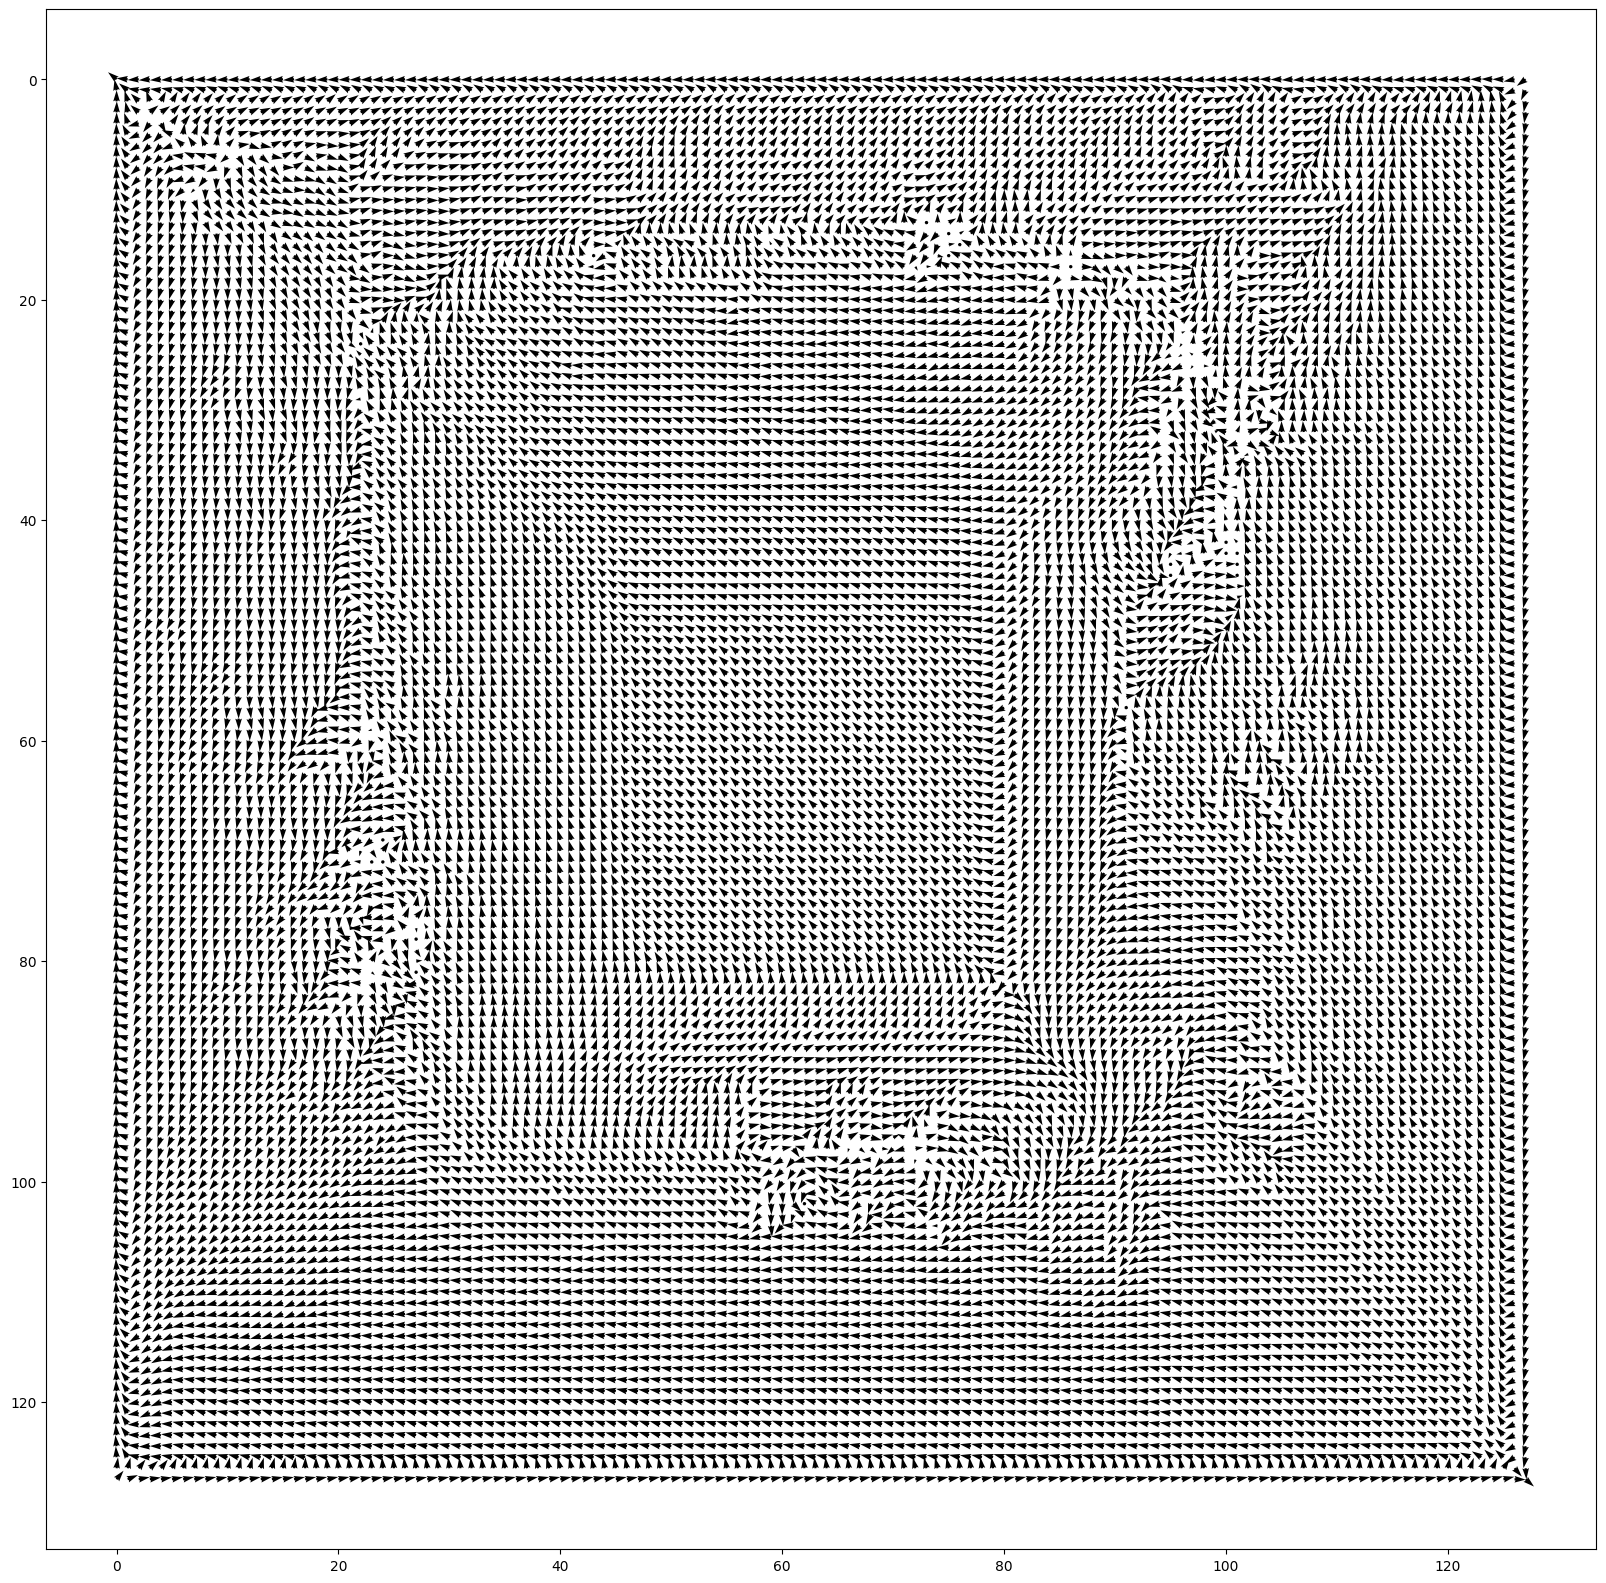

In [10]:
i = 8
data = score_fields[i][0]
def clip_batch_vectors(vector_field, max_mag=1.0):
    U, V = vector_field[...,0], vector_field[...,1]
    
    mag = torch.sqrt(U**2 + V**2)
    clipped_mags = torch.clamp(mag, max=max_mag)
    scale_factors = clipped_mags / (mag + 1e-9)
    
    U_clipped = U * scale_factors
    V_clipped = V * scale_factors
    
    return torch.stack((U_clipped, V_clipped), dim=-1)
# data = clip_batch_vectors(data, 0.001)
V = data[...,0]
U = data[...,1]

V_clip, U_clip = clip_vectors(V, U, 0.01)
# V_clip, U_clip = V, U
x, y = np.meshgrid(np.linspace(0, img_size-1, img_size), np.linspace(0,img_size-1,img_size))
plt.figure(figsize=(20, 20))
plt.quiver(x, y, U_clip.detach().cpu().numpy(), V_clip.detach().cpu().numpy(), angles='xy', scale_units='xy', scale=0.01)
plt.gca().invert_yaxis()
plt.show()

In [17]:
np.save('./results/heat/eval.npy', ims)

In [ ]:
# Evaluation - Multi goals

c = 10
fig,axs = plt.subplots(1, c + 1, figsize=(20,20))
axs = axs.flatten()
T = diffusion.noise_steps
step_size = int(T / c)
dot_size = 2

goals = gen_goals(goal_bounds, goal_num)

objs = wastes.copy()
gs = goals.clone()

obs_T = overlay_images(bg, img_size, objs, gs)

imgs = []

model.eval()
with torch.no_grad():
    # x_T = torch.tensor([[0.5, 0.5]], device=device, dtype=torch.float32)
    x_T = gen_goals(agent_bounds, n=(1, eval_samples)).unsqueeze(0)
    x = x_T
    
    imgs=[]
    for i in tqdm(reversed(range(1, noise_steps)), position=0):
        if (T-1-i) % step_size == 0:
            k = (T-1-i) // step_size
            img_sample = overlay_goals_agent(bg, objs, gs.cpu(), x.cpu(), dot_size)
            axs[k].imshow(img_sample)
            axs[k].set_title(f't = {T-1-i}')
            axs[k].axis('off')
            imgs.append(img_sample)

        t = (torch.ones(1) * i).long().to(device)
        while True:
            predicted_noise = model(obs_T, x, t)
            alpha = diffusion.alpha[t]
            alpha_hat = diffusion.alpha_hat[t]
            beta = diffusion.beta[t]
            if i > 1:
                noise = torch.randn_like(x)
            else:
                noise = torch.zeros_like(x)
            x = 1 / torch.sqrt(alpha) * (x - ((1 - alpha) / (torch.sqrt(1 - alpha_hat))) \
                        * predicted_noise) + torch.sqrt(beta) * noise
            # if (abs(x[0][0]) <= 1.) & (abs(x[0][1]) <= 1.):
            #     break
            mask = (x.abs() > 1)
            x[mask] = torch.clamp(x[mask], min=-.9, max=.9)
            if (x.abs() <=1).all():
                break

#         exclude_idx = -1
#         for i in range(len(gs)):
#             if get_distance(x[0], gs[i]) < 0.1 and len(gs) > 1:
#                 exclude_idx = i
#                 break
#         if exclude_idx > -1:
#             objs = objs[:i] + objs[i+1:]
#             gs = torch.cat([gs[:i], gs[i+1:]], dim=0)
#             obs_T = overlay_images(bg, img_size, objs, gs)

    img_sample = overlay_goals_agent(bg, objs, gs.cpu(),x.cpu(), dot_size)
    axs[-1].imshow(img_sample)
    axs[-1].set_title(f't = {T}')
    axs[-1].axis('off')
    imgs.append(img_sample)

In [ ]:
np.save('./results/new_goals_video/img_list.npy', imgs)